<a href="https://colab.research.google.com/github/navonilmandal/deepfake_video_detection_project/blob/main/deepfake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# --- Cell 1: Mount Google Drive & set paths ---

from google.colab import drive
import os   # <-- this import was missing

# Mount Drive
drive.mount('/content/drive')

# Dataset structure (edit if needed)
# Expected:
# /content/drive/MyDrive/deepfake_dataset/
#     ├── real/
#     └── fake/
DATASET_DIR = '/content/drive/MyDrive/deepfake_dataset'

# Working directories inside Colab
PROJECT_DIR = '/content/deepfake_project'
EXTRACTED_DIR = '/content/extracted_faces'
os.makedirs(PROJECT_DIR, exist_ok=True)
os.makedirs(EXTRACTED_DIR, exist_ok=True)

print("Dataset directory exists:", os.path.exists(DATASET_DIR))
if os.path.exists(DATASET_DIR):
    print("Classes found:", os.listdir(DATASET_DIR))
else:
    print("⚠️ Please upload your dataset to:", DATASET_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset directory exists: True
Classes found: ['fake', 'real']


In [36]:
# Only run if you get ImportError for sklearn/matplotlib/tqdm
!pip install -q scikit-learn matplotlib tqdm


In [37]:
import os, glob, random, shutil, math, time
from pathlib import Path
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Config - tune these if needed
FRAME_SIZE = 224          # input size for ResNet
FRAMES_PER_VIDEO = 8      # frames sampled per video
BATCH_SIZE = 16
EPOCHS = 10
LR = 1e-4
NUM_WORKERS = 2
CLASSES = ['real','fake']  # expected class folder names


Device: cuda


In [38]:
# --- Cell 4: Haar-cascade face extraction (run once) ---

import cv2, numpy as np
from PIL import Image
from tqdm import tqdm
import os, glob

haar = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier(haar)
print("Using Haar cascade:", haar)

# Make sure output folders exist
for cls in ['real', 'fake']:
    os.makedirs(os.path.join(EXTRACTED_DIR, cls), exist_ok=True)

for cls in ['real', 'fake']:
    src = os.path.join(DATASET_DIR, cls)
    dst = os.path.join(EXTRACTED_DIR, cls)
    videos = sorted(glob.glob(os.path.join(src, '*')))
    print(f"\nClass '{cls}': {len(videos)} videos -> extracting faces ...")

    for vp in tqdm(videos):
        base = os.path.splitext(os.path.basename(vp))[0]
        cap = cv2.VideoCapture(vp)
        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
        if total <= 0:
            cap.release()
            continue

        indices = np.linspace(0, total-1, min(FRAMES_PER_VIDEO, total), dtype=int)
        saved = 0
        for i, idx in enumerate(indices):
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
            ret, frame = cap.read()
            if not ret:
                continue

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4, minSize=(60,60))

            if len(faces) == 0:
                # fallback: center crop
                h, w = frame.shape[:2]
                cx, cy = w // 2, h // 2
                x1, y1 = max(0, cx - 112), max(0, cy - 112)
                crop = frame[y1:y1 + 224, x1:x1 + 224]
            else:
                x, y, wf, hf = faces[0]
                crop = frame[y:y + hf, x:x + wf]

            try:
                crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
                img = Image.fromarray(crop_rgb).resize((FRAME_SIZE, FRAME_SIZE))
                fname = f"{base}_f{i}.jpg"
                img.save(os.path.join(dst, fname))
                saved += 1
                if saved >= FRAMES_PER_VIDEO:
                    break
            except Exception:
                continue

        cap.release()

# Summary counts
for cls in ['real', 'fake']:
    cnt = len(glob.glob(os.path.join(EXTRACTED_DIR, cls, '*.jpg')))
    print(f"{cls}: {cnt} face images saved")


Using Haar cascade: /usr/local/lib/python3.12/dist-packages/cv2/data/haarcascade_frontalface_default.xml

Class 'real': 53 videos -> extracting faces ...


100%|██████████| 53/53 [01:18<00:00,  1.48s/it]



Class 'fake': 53 videos -> extracting faces ...


100%|██████████| 53/53 [01:04<00:00,  1.22s/it]

real: 424 face images saved
fake: 424 face images saved


In [39]:
# --- Cell 5: Prepare image lists and train/val/test splits ---

from sklearn.model_selection import train_test_split
import glob, os

# Collect image paths and labels
image_paths, labels = [], []
for i, cls in enumerate(['real', 'fake']):
    folder = os.path.join(EXTRACTED_DIR, cls)
    for p in glob.glob(os.path.join(folder, '*.jpg')):
        image_paths.append(p)
        labels.append(i)

print("Total images:", len(image_paths))

# Split data: 80% train → 20% test; then 80% train → 20% val
train_x, test_x, train_y, test_y = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)
train_x, val_x, train_y, val_y = train_test_split(
    train_x, train_y, test_size=0.2, stratify=train_y, random_state=42
)

print("Train:", len(train_x), "Val:", len(val_x), "Test:", len(test_x))


Total images: 848
Train: 542 Val: 136 Test: 170


In [40]:
# --- Cell 6: Dataset & DataLoader setup ---

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

# Image transforms
train_tf = T.Compose([
    T.RandomResizedCrop(224, scale=(0.8,1.0)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_tf = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Custom Dataset
class FaceDataset(Dataset):
    def __init__(self, paths, labels, transform):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# DataLoaders
BATCH_SIZE = 16
train_loader = DataLoader(FaceDataset(train_x, train_y, train_tf), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(FaceDataset(val_x, val_y, val_tf), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(FaceDataset(test_x, test_y, val_tf), batch_size=BATCH_SIZE, shuffle=False)

print(f"Data ready ✅ | Train: {len(train_loader)} batches | Val: {len(val_loader)} | Test: {len(test_loader)}")


Data ready ✅ | Train: 34 batches | Val: 9 | Test: 11


In [41]:
# --- Cell 7: Define model, optimizer, and loss function ---

import torchvision.models as models
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use ResNet-18 pretrained on ImageNet
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes: real/fake
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("✅ Model initialized (ResNet-18)")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Model initialized (ResNet-18)


In [42]:
# --- Cell 8: Training loop with validation & best model save ---

from sklearn.metrics import accuracy_score
import torch

EPOCHS = 10
best_val_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0
    preds_all, labs_all = [], []

    for imgs, labs in train_loader:
        imgs, labs = imgs.to(device), labs.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds_all += torch.argmax(outputs, dim=1).cpu().tolist()
        labs_all += labs.cpu().tolist()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = accuracy_score(labs_all, preds_all)

    # Validation
    model.eval()
    val_preds, val_labs = [], []
    with torch.no_grad():
        for imgs, labs in val_loader:
            imgs, labs = imgs.to(device), labs.to(device)
            outputs = model(imgs)
            val_preds += torch.argmax(outputs, dim=1).cpu().tolist()
            val_labs += labs.cpu().tolist()

    val_acc = accuracy_score(val_labs, val_preds)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/content/best_model_resnet18.pth')
        print("🌟 Saved best model (Val acc improved).")


Epoch 1/10 | Train Loss: 0.4354 | Train Acc: 0.7804 | Val Acc: 0.8603
🌟 Saved best model (Val acc improved).
Epoch 2/10 | Train Loss: 0.1776 | Train Acc: 0.9077 | Val Acc: 0.8088
Epoch 3/10 | Train Loss: 0.1310 | Train Acc: 0.9502 | Val Acc: 0.8162
Epoch 4/10 | Train Loss: 0.1465 | Train Acc: 0.9354 | Val Acc: 0.8309
Epoch 5/10 | Train Loss: 0.1155 | Train Acc: 0.9539 | Val Acc: 0.8382
Epoch 6/10 | Train Loss: 0.1311 | Train Acc: 0.9428 | Val Acc: 0.9118
🌟 Saved best model (Val acc improved).
Epoch 7/10 | Train Loss: 0.0918 | Train Acc: 0.9520 | Val Acc: 0.8971
Epoch 8/10 | Train Loss: 0.0868 | Train Acc: 0.9631 | Val Acc: 0.9118
Epoch 9/10 | Train Loss: 0.0662 | Train Acc: 0.9686 | Val Acc: 0.8824
Epoch 10/10 | Train Loss: 0.0936 | Train Acc: 0.9668 | Val Acc: 0.9191
🌟 Saved best model (Val acc improved).


In [43]:
# --- Cell 9: Test evaluation (frame-level) ---
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import numpy as np

# Load best model (if you want to evaluate the best saved one)
try:
    model.load_state_dict(torch.load('/content/best_model_resnet18.pth', map_location=device))
    print("Loaded best_model_resnet18.pth")
except Exception as e:
    print("Could not load best model, using current model in memory.", e)

model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for imgs, labs in test_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        probs = torch.softmax(logits, dim=1)[:,1].cpu().numpy()  # probability for class index 1 (fake)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_probs.extend(probs.tolist())
        all_preds.extend(preds.tolist())
        all_labels.extend(labs)

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

print("Test accuracy:", accuracy_score(all_labels, all_preds))
try:
    print("Test AUC:", roc_auc_score(all_labels, all_probs))
except Exception as e:
    print("Could not compute AUC:", e)

print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=['real','fake']))
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))


Loaded best_model_resnet18.pth
Test accuracy: 0.8764705882352941
Test AUC: 0.9724567474048443

Classification Report:
               precision    recall  f1-score   support

        real       0.84      0.93      0.88        85
        fake       0.92      0.82      0.87        85

    accuracy                           0.88       170
   macro avg       0.88      0.88      0.88       170
weighted avg       0.88      0.88      0.88       170

Confusion Matrix:
 [[79  6]
 [15 70]]


In [44]:
# --- Cell A: Grad-CAM implementation (for ResNet-style models) ---
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os

class GradCAM:
    def __init__(self, model, target_layer):
        """
        model: PyTorch model (eval mode expected)
        target_layer: the convolutional layer to use for CAM (module)
        """
        self.model = model
        self.model.eval()
        self.target_layer = target_layer

        # placeholders for activations and gradients
        self.activations = None
        self.gradients = None

        # register hooks
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            # grad_out is a tuple; take the first
            self.gradients = grad_out[0].detach()
        self.fwd_hook = self.target_layer.register_forward_hook(forward_hook)
        self.bwd_hook = self.target_layer.register_backward_hook(backward_hook)

    def __del__(self):
        try:
            self.fwd_hook.remove()
            self.bwd_hook.remove()
        except Exception:
            pass

    def generate(self, input_tensor, class_idx=None):
        """
        input_tensor: single-image tensor with batch dim (1,C,H,W) on same device as model
        class_idx: index of class to compute CAM for (if None uses predicted class)
        returns: heatmap (H,W) normalized 0..1
        """
        device = next(self.model.parameters()).device
        input_tensor = input_tensor.to(device)
        # forward
        logits = self.model(input_tensor)
        if class_idx is None:
            class_idx = int(torch.argmax(logits, dim=1).cpu().numpy()[0])
        # backward from the chosen class logit
        self.model.zero_grad()
        target = logits[0, class_idx]
        target.backward(retain_graph=True)

        # get activations (A) and gradients (dA)
        A = self.activations[0]            # shape (C, H, W)
        dA = self.gradients[0]             # shape (C, H, W)

        # global-average-pool gradients -> weights
        weights = torch.mean(dA.view(dA.size(0), -1), dim=1)  # (C,)

        # weighted sum of activations
        cam = torch.zeros(A.shape[1:], dtype=torch.float32, device=A.device)  # (H,W)
        for i, w in enumerate(weights):
            cam += w * A[i]
        cam = cam.cpu().numpy()
        # relu and normalize
        cam = np.maximum(cam, 0)
        if cam.max() > 0:
            cam = cam - cam.min()
            cam = cam / (cam.max() + 1e-8)
        else:
            cam = np.zeros_like(cam)

        # resize to input size
        _, _, H, W = input_tensor.shape
        cam = cv2.resize(cam, (W, H))
        return cam, class_idx, logits.detach().cpu().numpy()[0]

def apply_colormap_on_image(org_img: np.ndarray, activation_map: np.ndarray, colormap=cv2.COLORMAP_JET, alpha=0.4):
    """
    org_img: HxW x RGB uint8
    activation_map: HxW float [0..1]
    returns: overlayed image (uint8)
    """
    heatmap = np.uint8(255 * activation_map)
    heatmap = cv2.applyColorMap(heatmap, colormap)  # BGR
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = heatmap.astype(np.float32) / 255.0
    img = org_img.astype(np.float32) / 255.0
    overlay = img * (1.0 - alpha) + heatmap * alpha
    overlay = np.clip(overlay * 255.0, 0, 255).astype(np.uint8)
    return overlay

# Helper to get last conv layer for ResNet-18
def get_resnet_target_layer(model):
    # target: last layer of layer4, typically model.layer4[-1].conv2
    try:
        return model.layer4[-1].conv2
    except Exception:
        # fallback: use the whole layer4
        return model.layer4

print("GradCAM helper ready.")


GradCAM helper ready.


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


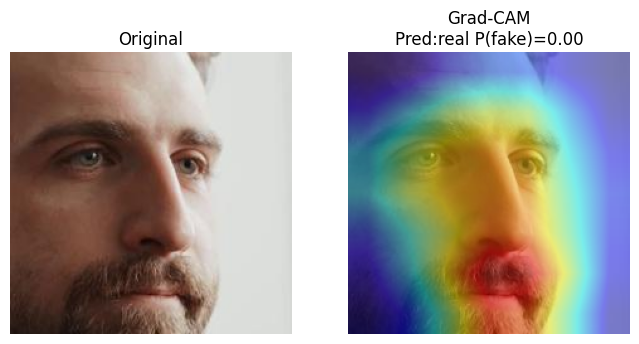

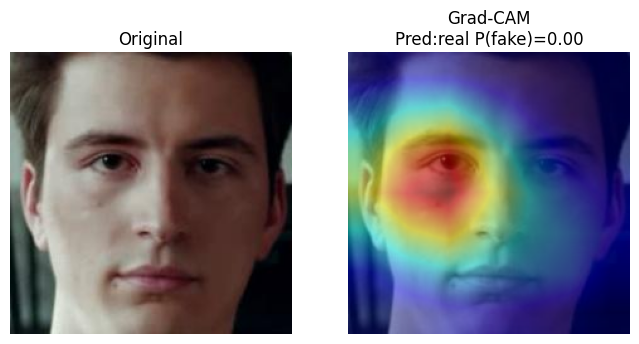

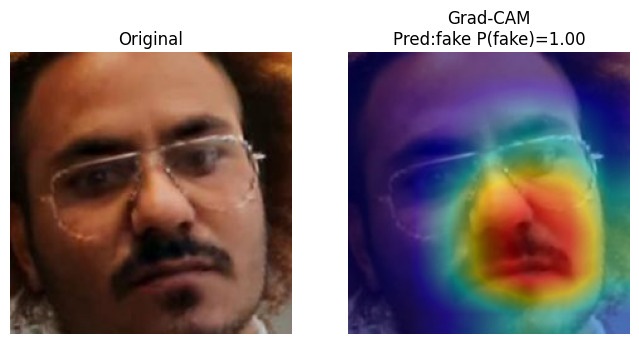

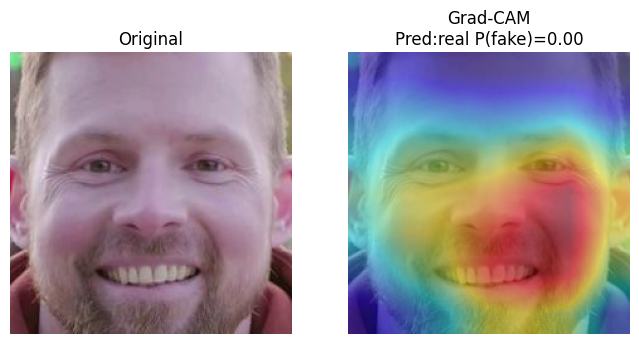

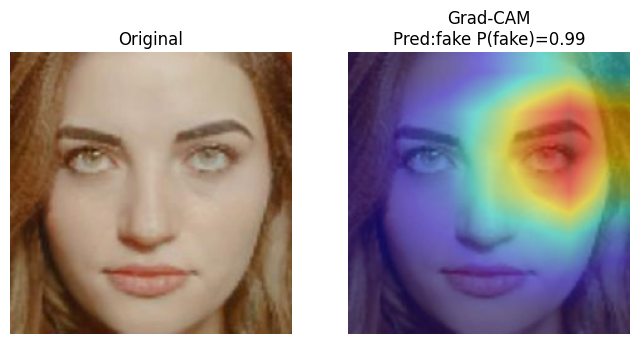

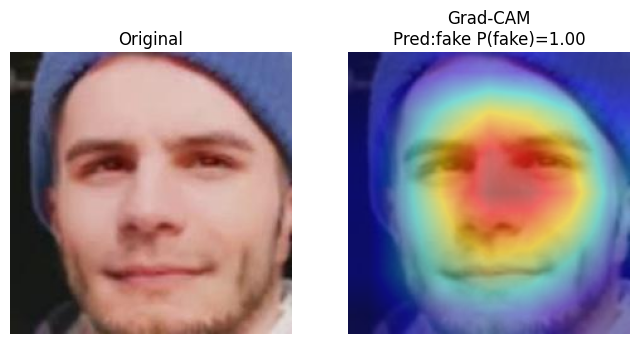

Saved Grad-CAM overlays to: /content/gradcam_outputs
Files: ['gradcam_3_v1_f1.jpg', 'gradcam_0_v6_f7.jpg', 'gradcam_2_vs32_f1.jpg', 'gradcam_5_vs48_f1.jpg', 'gradcam_3_v29_f1.jpg', 'gradcam_2_v48_f5.jpg', 'gradcam_0_v27_f6.jpg', 'gradcam_1_vs25_f1.jpg', 'gradcam_5_vs37_f6.jpg', 'gradcam_4_vs29_f2.jpg', 'gradcam_4_vs37_f6.jpg', 'gradcam_1_v51_f6.jpg']


In [45]:
# --- Cell B: Run Grad-CAM on sample test images and display/save results ---

import random
from PIL import Image

# Ensure model is in eval mode and on device
model.eval()
model.to(device)

# Choose target layer for ResNet-18
target_layer = get_resnet_target_layer(model)
gc = GradCAM(model, target_layer)

OUT_DIR = '/content/gradcam_outputs'
os.makedirs(OUT_DIR, exist_ok=True)

def run_and_show_gradcam(img_path, save_path=None, show=True):
    # Load original image (PIL), prepare tensor using val_tf
    pil = Image.open(img_path).convert('RGB').resize((224,224))
    tensor = val_tf(pil).unsqueeze(0)  # val_tf should be defined in notebook
    cam_map, class_idx, logits = gc.generate(tensor, class_idx=None)
    # Original as numpy
    org = np.array(pil)
    overlay = apply_colormap_on_image(org, cam_map, alpha=0.45)
    pred_label = 'fake' if logits.argmax() == 1 else 'real'
    pred_prob_fake = float(torch.softmax(torch.tensor(logits), dim=0)[1].item())
    if show:
        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1); plt.imshow(org); plt.title("Original"); plt.axis('off')
        plt.subplot(1,2,2); plt.imshow(overlay); plt.title(f"Grad-CAM\nPred:{pred_label} P(fake)={pred_prob_fake:.2f}"); plt.axis('off')
        plt.show()
    if save_path:
        Image.fromarray(overlay).save(save_path)
    return {'overlay': overlay, 'pred_label': pred_label, 'prob_fake': pred_prob_fake}

# Run Grad-CAM on 6 random test images (or fewer if not enough)
num_to_show = min(6, len(test_x))
samples = random.sample(test_x, num_to_show)
saved_paths = []
for i, p in enumerate(samples):
    outp = os.path.join(OUT_DIR, f"gradcam_{i}_{os.path.basename(p)}")
    res = run_and_show_gradcam(p, save_path=outp)
    saved_paths.append(outp)

print("Saved Grad-CAM overlays to:", OUT_DIR)
print("Files:", os.listdir(OUT_DIR)[:20])


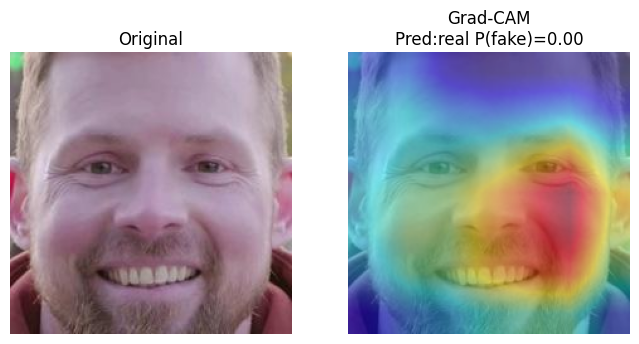

Saved frame Grad-CAM to /content/gradcam_frame.jpg


In [46]:
# --- Optional: Grad-CAM on a single frame from a video ---
video_path = '/content/drive/MyDrive/deepfake_dataset/real/v1.mp4'  # change to a real file
cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, 10)  # choose a frame index
ret, frame = cap.read(); cap.release()
if not ret:
    print("Could not read frame")
else:
    # detect face and crop using Haar (fallback if face_cascade exists)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4, minSize=(60,60))
    if len(faces) == 0:
        h,w = frame.shape[:2]; crop = frame[max(0,h//2-112):h//2+112, max(0,w//2-112):w//2+112]
    else:
        x,y,wf,hf = faces[0]; crop = frame[y:y+hf, x:x+wf]
    # prepare and run Grad-CAM
    crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(crop_rgb).resize((224,224))
    out = run_and_show_gradcam_img = None
    res = run_and_show_gradcam_func = None
    # call the same helper but bypassing file path:
    img_path_tmp = '/content/tmp_frame.jpg'
    Image.fromarray(crop_rgb).resize((224,224)).save(img_path_tmp)
    run_and_show_gradcam(img_path_tmp, save_path='/content/gradcam_frame.jpg', show=True)
    print("Saved frame Grad-CAM to /content/gradcam_frame.jpg")


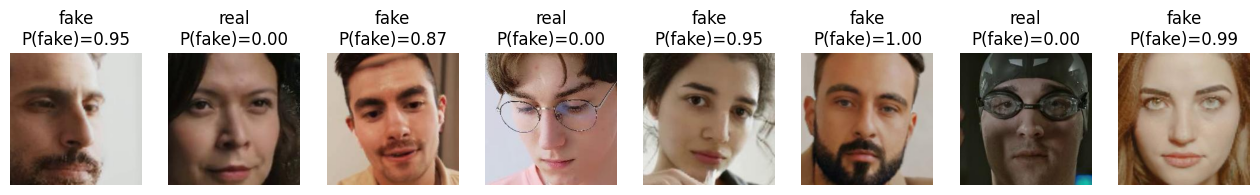

In [47]:
# --- Cell 10: Show a few test images with model predictions (for professor demo) ---
import matplotlib.pyplot as plt
from PIL import Image
import random

def show_samples(n=8):
    sample_idxs = random.sample(range(len(test_x)), min(n, len(test_x)))
    plt.figure(figsize=(16,4))
    for i, idx in enumerate(sample_idxs):
        path = test_x[idx]
        img = Image.open(path).convert('RGB').resize((224,224))
        tensor = val_tf(img).unsqueeze(0).to(device)
        with torch.no_grad():
            out = model(tensor)
            prob_fake = float(torch.softmax(out, dim=1)[0,1].cpu().item())
            pred = 'fake' if prob_fake > 0.5 else 'real'
        plt.subplot(1, n, i+1)
        plt.imshow(img); plt.title(f"{pred}\nP(fake)={prob_fake:.2f}")
        plt.axis('off')
    plt.show()

show_samples(8)


In [48]:
# --- Cell 11: Video-level inference using Haar face crops (aggregates frame probs) ---
import cv2, numpy as np
from PIL import Image

def predict_video(video_path, model, device, frames_to_sample=FRAMES_PER_VIDEO):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    if total <= 0:
        cap.release()
        return None
    inds = np.linspace(0, total-1, min(frames_to_sample, total), dtype=int)
    probs = []
    with torch.no_grad():
        for idx in inds:
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
            ret, frame = cap.read()
            if not ret:
                continue
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4, minSize=(60,60))
            if len(faces) == 0:
                h,w = frame.shape[:2]
                crop = frame[max(0,h//2-112):h//2+112, max(0,w//2-112):w//2+112]
            else:
                x,y,wf,hf = faces[0]
                crop = frame[y:y+hf, x:x+wf]
            try:
                crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
                img = Image.fromarray(crop_rgb).resize((FRAME_SIZE, FRAME_SIZE))
                t = val_tf(img).unsqueeze(0).to(device)
                out = model(t)
                prob_fake = torch.softmax(out, dim=1)[0,1].item()
                probs.append(prob_fake)
            except Exception:
                continue
    cap.release()
    if len(probs) == 0:
        return None
    avg_prob = float(np.mean(probs))
    label = 'fake' if avg_prob > 0.5 else 'real'
    return {'predicted_label': label, 'avg_prob_fake': avg_prob, 'frames_used': len(probs)}

# Example usage:
# print(predict_video('/content/drive/MyDrive/deepfake_dataset/real/your_video.mp4', model, device))


In [49]:
# --- Cell 12: Save final/best model to Drive for submission ---
import shutil, os
os.makedirs('/content/drive/MyDrive/deepfake_project', exist_ok=True)
src = '/content/best_model_resnet18.pth'
if not os.path.exists(src):
    # if trained-best was saved under a different name in your session
    src = '/content/best_model_resnet18.pth' if os.path.exists('/content/best_model_resnet18.pth') else '/content/best_model_resnet18.pth'
# Save current in-memory model as fallback
torch.save({'model_state_dict': model.state_dict(), 'classes': ['real','fake']}, '/content/tmp_model_resnet18.pth')
shutil.copy('/content/tmp_model_resnet18.pth', '/content/drive/MyDrive/deepfake_project/best_model_resnet18.pth')
print("Saved model to /content/drive/MyDrive/deepfake_project/best_model_resnet18.pth")


Saved model to /content/drive/MyDrive/deepfake_project/best_model_resnet18.pth


In [58]:
# Upload a new video file from your computer, or set drive_path to use a file already in Drive.
from google.colab import files
import os, shutil

# Option 1: Upload from local machine (will appear in Colab VM)
print("Click to upload a video file (mp4, mov, mkv...).")
uploaded = files.upload()  # choose one file

if len(uploaded) == 0:
    print("No file uploaded. If you want to use a file from Drive, set drive_path below and skip upload.")
else:
    # take the first uploaded file
    fname = list(uploaded.keys())[0]
    uploaded_path = os.path.join('/content', fname)
    print("Uploaded to:", uploaded_path)

# Option 2: OR use a file already in Google Drive (set drive_path)
# Example: drive_path = '/content/drive/MyDrive/some_video.mp4'
drive_path = None  # <-- if you have a Drive file, set this string
if drive_path:
    video_path = drive_path
elif len(uploaded) > 0:
    video_path = uploaded_path
else:
    raise RuntimeError("No video provided. Upload one or set drive_path variable.")

print("Using video:", video_path)


Click to upload a video file (mp4, mov, mkv...).


Saving vs25.mp4 to vs25 (1).mp4
Uploaded to: /content/vs25 (1).mp4
Using video: /content/vs25 (1).mp4


In [59]:
# --- Video prediction cell ---
# This re-defines a robust predict_video function (uses face_cascade, val_tf, model, device).
# It will try OpenCV first and ffmpeg fallback if needed.

import cv2, numpy as np, os, subprocess
from PIL import Image
import torch

# Ensure these variables exist from earlier cells: model, device, val_tf, face_cascade, FRAME_SIZE, FRAMES_PER_VIDEO
# If they don't, we attempt to load the saved model from Drive.
if 'model' not in globals():
    # try load from Drive location
    try:
        ck = torch.load('/content/drive/MyDrive/deepfake_project/best_model_resnet18.pth', map_location='cpu')
        import torchvision.models as models, torch.nn as nn
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, 2)
        model.load_state_dict(ck['model_state_dict'])
        model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
        device = next(model.parameters()).device
        print("Loaded model from Drive. Device:", device)
    except Exception as e:
        raise RuntimeError("Model not found in memory or Drive. Ensure you've trained and saved the model or run training cells.") from e

# helpers to read a frame robustly
def try_read_frame_opencv(vpath, frame_idx=10):
    cap = cv2.VideoCapture(vpath)
    if not cap.isOpened():
        cap.release()
        return None, "could not open"
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    if total == 0:
        cap.release()
        return None, f"zero frames (total={total})"
    frame_idx = max(0, min(frame_idx, total-1))
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        return None, "read failed"
    return frame, None

def try_ffmpeg_extract(vpath, frame_idx=10, out='/content/ffmpeg_frame.jpg'):
    if not os.path.exists(vpath):
        return None, "file not found"
    if os.path.exists(out):
        os.remove(out)
    cmd = [
        'ffmpeg', '-y', '-ss', str(frame_idx), '-i', vpath,
        '-frames:v', '1', '-q:v', '2', out
    ]
    try:
        subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)
        if os.path.exists(out):
            import numpy as np
            from PIL import Image
            img = Image.open(out).convert('RGB')
            return np.array(img), None
        else:
            return None, "ffmpeg produced no output"
    except Exception as e:
        return None, f"ffmpeg error: {e}"

# predict_video aggregates frame-level fake probabilities
def predict_video(video_path, model, device, frames_to_sample=FRAMES_PER_VIDEO):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    cap.release()
    if total <= 0:
        # fallback: try ffmpeg to check length by extracting a frame
        frame, err = try_ffmpeg_extract(video_path, frame_idx=0, out='/content/ffprobe_try.jpg')
        if frame is None:
            raise RuntimeError(f"Video unreadable by both OpenCV and ffmpeg: {err}")
        total = 1

    inds = np.linspace(0, total-1, min(frames_to_sample, total), dtype=int)
    probs = []
    for idx in inds:
        # try opencv for each frame
        frame, err = try_read_frame_opencv(video_path, frame_idx=int(idx))
        if frame is None:
            # try ffmpeg fallback for this frame
            frame, err2 = try_ffmpeg_extract(video_path, frame_idx=int(idx), out='/content/ffmpeg_frame_tmp.jpg')
            if frame is None:
                # skip this frame
                continue
            frame_rgb = frame  # ffmpeg returned RGB numpy
        else:
            # opencv returned BGR
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # detect face using Haar cascade (face_cascade must exist)
        try:
            gray = cv2.cvtColor(frame if frame is not None else cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR), cv2.COLOR_BGR2GRAY)
        except Exception:
            gray = cv2.cvtColor(cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR), cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4, minSize=(60,60))
        if len(faces) == 0:
            # center crop fallback
            h,w = frame_rgb.shape[:2]
            cx, cy = w//2, h//2
            x1, y1 = max(0, cx-112), max(0, cy-112)
            crop = frame_rgb[y1:y1+224, x1:x1+224]
        else:
            x,y,wf,hf = faces[0]
            crop = frame_rgb[y:y+hf, x:x+wf]

        # preprocess and predict
        try:
            pil = Image.fromarray(crop).resize((FRAME_SIZE, FRAME_SIZE))
            tensor = val_tf(pil).unsqueeze(0).to(device)
            with torch.no_grad():
                out = model(tensor)
                prob_fake = torch.softmax(out, dim=1)[0,1].item()  # class index 1 => 'fake'
                probs.append(prob_fake)
        except Exception:
            continue

    if len(probs) == 0:
        return {'error': 'no usable face frames found'}
    avg_prob = float(np.mean(probs))
    pred_label = 'fake' if avg_prob >= 0.5 else 'real'
    return {'predicted_label': pred_label, 'avg_prob_fake': avg_prob, 'frames_used': len(probs), 'per_frame_probs': probs}

# Run prediction on the uploaded video_path variable from Cell A
print("Running prediction on:", video_path)
res = predict_video(video_path, model, device, frames_to_sample=FRAMES_PER_VIDEO)
print("Result:", res)


Running prediction on: /content/vs25 (1).mp4
Result: {'predicted_label': 'fake', 'avg_prob_fake': 0.9993862584233284, 'frames_used': 8, 'per_frame_probs': [0.9991866946220398, 0.999239444732666, 0.9990636706352234, 0.9995948672294617, 0.9992668032646179, 0.9987704157829285, 0.999990701675415, 0.9999774694442749]}


In [60]:
# --- Define gradcam_on_pil helper (for a single PIL image) ---
import torch, numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def gradcam_on_pil(pil_img, show=True, save_path='/content/gradcam_frame_overlay.jpg'):
    """
    Run Grad-CAM on a PIL image using global gc/model/val_tf.
    Returns dict with overlay path and prediction info.
    """
    if 'gc' not in globals():
        raise RuntimeError("GradCAM object (gc) not defined. Run the Grad-CAM Cell A first.")
    if 'val_tf' not in globals():
        raise RuntimeError("val_tf transform missing. Run the earlier data-prep cells.")

    # Preprocess image → tensor
    tensor = val_tf(pil_img).unsqueeze(0).to(device)
    cam_map, class_idx, logits = gc.generate(tensor, class_idx=None)

    # Create overlay
    org = np.array(pil_img.resize((224, 224)))
    overlay = apply_colormap_on_image(org, cam_map, alpha=0.45)
    pred_label = 'fake' if logits.argmax() == 1 else 'real'
    pred_prob_fake = float(torch.softmax(torch.tensor(logits), dim=0)[1].item())

    # Display
    if show:
        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1); plt.imshow(org); plt.title("Original"); plt.axis('off')
        plt.subplot(1,2,2); plt.imshow(overlay)
        plt.title(f"Grad-CAM\nPred:{pred_label}  P(fake)={pred_prob_fake:.2f}")
        plt.axis('off'); plt.show()

    Image.fromarray(overlay).save(save_path)
    print("Overlay saved to:", save_path)
    return {'overlay_path': save_path, 'pred_label': pred_label, 'prob_fake': pred_prob_fake}


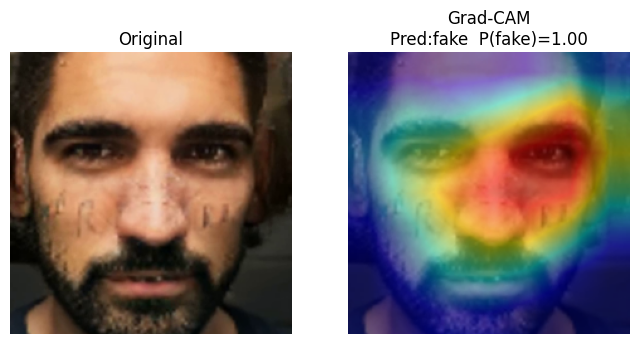

Overlay saved to: /content/gradcam_frame_overlay.jpg
Grad-CAM result: {'overlay_path': '/content/gradcam_frame_overlay.jpg', 'pred_label': 'fake', 'prob_fake': 0.999924898147583}


In [61]:
# --- Grad-CAM overlay on a representative frame from the video ---
# Requires Grad-CAM helpers from earlier (gc, apply_colormap_on_image, get_resnet_target_layer).
# If you didn't run Grad-CAM cells yet, run Cell A (Grad-CAM implementation) first.

from PIL import Image
import numpy as np

# try to get a frame (prefer a frame used in prediction if available)
# We'll read frame index  max(0, total//4) as representative
def extract_one_frame(video_path, idx=10):
    import cv2
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    if total == 0:
        cap.release()
        return None
    idx = max(0, min(idx, total-1))
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        return None
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

frame_rgb = extract_one_frame(video_path, idx=10)
if frame_rgb is None:
    print("Could not extract frame for Grad-CAM preview.")
else:
    # crop face with Haar cascade as used before
    gray = cv2.cvtColor(cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR), cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4, minSize=(60,60))
    if len(faces) == 0:
        h,w = frame_rgb.shape[:2]; crop = frame_rgb[max(0,h//2-112):h//2+112, max(0,w//2-112):w//2+112]
    else:
        x,y,wf,hf = faces[0]; crop = frame_rgb[y:y+hf, x:x+wf]
    pil = Image.fromarray(crop).resize((224,224))
    # create or reuse GradCAM object (gc) — if not present, create it
    if 'gc' not in globals():
        target_layer = get_resnet_target_layer(model)
        gc = GradCAM(model, target_layer)
    out = gradcam_on_pil(pil)  # uses helper defined earlier in Grad-CAM cells
    print("Grad-CAM result:", out)
    # out includes overlay saved path


In [62]:
# Make sure your notebook and files are inside one clean folder
!mkdir -p /content/deepfake_project
!cp /content/best_model_resnet18.pth /content/deepfake_project/ 2>/dev/null
!cp /content/DeepFakeDetection.ipynb /content/deepfake_project/ 2>/dev/null

# Create a simple README
with open("/content/deepfake_project/README.md", "w") as f:
    f.write("# Deepfake Detection Project\nThis is an AI model built in Google Colab using PyTorch to detect fake vs real videos.\n")

# Create a simple requirements file
with open("/content/deepfake_project/requirements.txt", "w") as f:
    f.write("torch\nopencv-python-headless\nscikit-learn\nmatplotlib\ntqdm\nnumpy\nPillow\n")

print("✅ Project folder is ready.")
!ls /content/deepfake_project


✅ Project folder is ready.
best_model_resnet18.pth  README.md  requirements.txt
